In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import h5py

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt

from sociohydro import *

lw = 1
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = lw
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = lw
plt.rcParams['font.size'] = 6
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.25
plt.rcParams['image.origin'] = 'upper'
plt.rcParams['pcolor.shading'] = 'auto'
plt.rcParams['figure.dpi'] = 150

(100, 87) (100, 87) (100, 87)
(5, 100, 87) (5, 100, 87)
(8700, 2) (8700,) ()


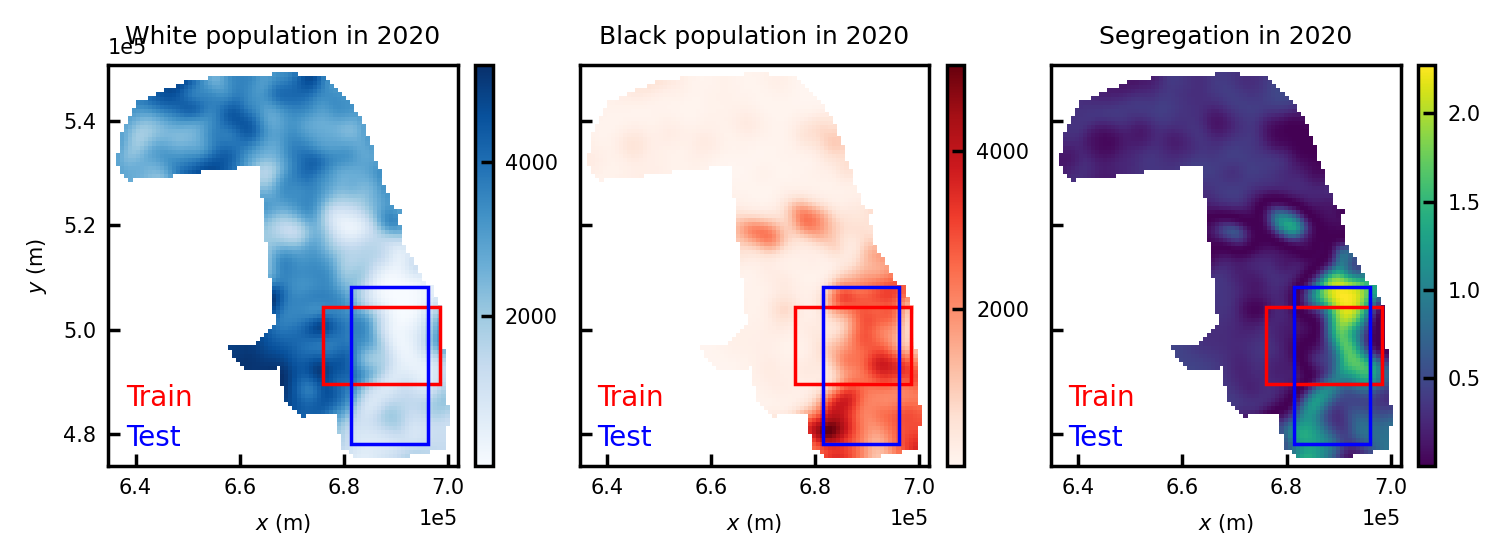

In [2]:
from matplotlib.patches import Rectangle
'''
Load and plot data from HDF5 files 
'''
with h5py.File("data/cook_IL.hdf5", "r") as d:
    x_grid = d["x_grid"][:]
    y_grid = d["y_grid"][:]
    w_grid_array_masked = d["w_grid_array_masked"][:].transpose(2, 0, 1)
    b_grid_array_masked = d["b_grid_array_masked"][:].transpose(2, 0, 1)
    
    for i in range(5):
        w_grid_array_masked[i] = smooth_with_fill(w_grid_array_masked[i])
        b_grid_array_masked[i] = smooth_with_fill(b_grid_array_masked[i])
        
    mask = d['mask'][:]

T = np.array([1980, 1990, 2000, 2010, 2020])
ii = 4
    
pop = np.array([w_grid_array_masked[ii].ravel(),
                b_grid_array_masked[ii].ravel()]).T
h, H = entropy_index(pop)
    
print(x_grid.shape, y_grid.shape, mask.shape)
print(w_grid_array_masked.shape, b_grid_array_masked.shape)
print(pop.shape, h.shape, H.shape)

plt.rcParams['pcolor.shading'] = 'auto'
plt.rcParams['figure.dpi'] = 250
fig, ax = plt.subplots(1, 3, sharey=True)

c0 = ax[0].pcolormesh(x_grid, y_grid, w_grid_array_masked[ii], cmap="Blues")
cax0 = ax[0].inset_axes([1.05, 0, 0.05, 1])
fig.colorbar(c0, ax=ax[0], cax=cax0, ticks=[0, 2000, 4000, 6000])

c1 = ax[1].pcolormesh(x_grid, y_grid, b_grid_array_masked[ii], cmap="Reds")
cax1 = ax[1].inset_axes([1.05, 0, 0.05, 1])
fig.colorbar(c1, ax=ax[1], cax=cax1, ticks=[0, 2000, 4000, 6000])

c2 = ax[2].pcolormesh(x_grid, y_grid, h.reshape(x_grid.shape), cmap="viridis")
cax2 = ax[2].inset_axes([1.05, 0, 0.05, 1])
fig.colorbar(c2, ax=ax[2], cax=cax2)

train_bbox = np.s_[20:40, 53:83]
test_bbox = np.s_[13:43, 51:81]
test_bbox = np.s_[5:45, 60:80]

for bbox, color in zip([train_bbox, test_bbox], ['red', 'blue']):
    x0, x1 = x_grid[bbox].min(), x_grid[bbox].max()
    y0, y1 = y_grid[bbox].min(), y_grid[bbox].max()
    
    for a in ax:
        rect = Rectangle((x0, y0), x1-x0, y1-y0, edgecolor=color, facecolor='none')
        a.add_patch(rect)
        


for a in ax.ravel():
    a.set_aspect(1)
    a.ticklabel_format(axis='both', scilimits=(0,0))
    a.set_xlabel('$x$ (m)')
    a.text(0.05, 0.15, 'Train', color='red', transform=a.transAxes, fontsize=8)
    a.text(0.05, 0.05, 'Test', color='blue', transform=a.transAxes, fontsize=8)
ax[0].set_ylabel('$y$ (m)')
ax[0].set_yticks([4.8e5, 5.0e5, 5.2e5, 5.4e5])

ax[0].set_title(f'White population in {T[ii]}')
ax[1].set_title(f'Black population in {T[ii]}')
ax[2].set_title(f'Segregation in {T[ii]}')

plt.tight_layout()

ConvLSTM 813.923828125
White 1980: y0: [99, 13854], y1: [99, 13854]
White 2000: y0: [38, 7021], y1: [0, 12895]
White 2020: y0: [63, 4999], y1: [0, 11404]
Black 1980: y0: [7, 5905], y1: [7, 5905]
Black 2000: y0: [28, 5512], y1: [104, 6003]
Black 2020: y0: [115, 3801], y1: [257, 6155]
Segregation 1980: y0: [0, 2], y1: [0, 2]
Segregation 2000: y0: [0, 1], y1: [0, 2]
Segregation 2020: y0: [0, 1], y1: [0, 1]
ConvLSTM 813.9271850585938


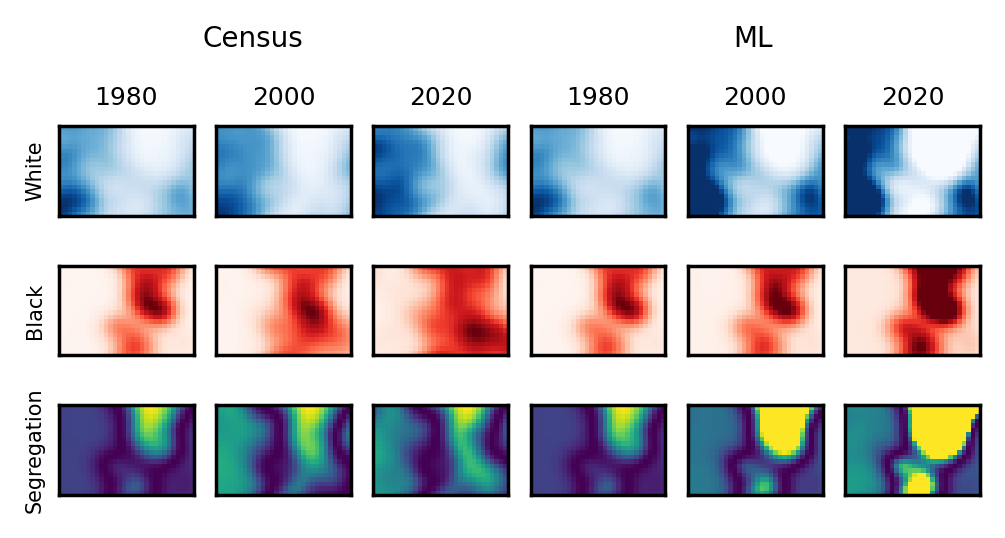

In [6]:
from run_socio_NODE import *
from run_socio_NN import *

plt.rcParams['image.origin'] = 'lower'

dataset = SociohydrodynamicsDataset(test_bbox=[20, 53, 20, 30])
#dataset = SociohydrodynamicsDataset(test_bbox=[5, 60, 40, 20])

device = torch.device('cuda:0')
name = 'ConvLSTM'
info = torch.load(f'data/{name}.ckpt', map_location='cpu')
print(name, info['loss'])
model = eval(name)(**info['hparams'])
model.load_state_dict(info['state_dict'])
model.to(device)

batch = dataset.test_batch
with torch.no_grad():
    t = batch['t'].to(device)
    wb = torch.stack([batch['w'], batch['b']], dim=-3).to(device)
    wb_pred = model(t, wb[0:1]).squeeze()
    wb_pred[wb_pred < 0] = 0
    loss = F.l1_loss(wb, wb_pred)
    
    wb = wb.cpu().numpy()
    wb_pred = wb_pred.cpu().numpy()    
 
    
#fig, ax = plt.subplots(3, 4, figsize=(3, 4))
fig, ax = plt.subplots(3, 6, figsize=(4, 2))


cmaps = ['Blues', 'Reds', 'viridis']
for j, label in enumerate(['White', 'Black', 'Segregation']):
    cmap = cmaps[j]

    for i, tt in enumerate([0, 2, 4]):
        if label == 'Segregation':
            y0 = seg(wb[tt, 0], wb[tt, 1])
            y1 = seg(wb_pred[tt, 0], wb_pred[tt, 1])
        else:
            y0 = wb[tt, j]
            y1 = wb_pred[tt, j]
            vmax = np.max(wb[:, j])

        print(f'{label} {dataset.t[tt]}: y0: [{y0.min():.0f}, {y0.max():.0f}], y1: [{y1.min():.0f}, {y1.max():.0f}]')
            
        vmax = np.max(y0)
        ax[j, i].imshow(y0, cmap=cmap, vmin=0, vmax=vmax)
        ax[0, i].set_title(dataset.t[tt])
        
        ax[j, 3+i].imshow(y1, cmap=cmap, vmin=0, vmax=vmax)
        ax[0, 3+i].set_title(dataset.t[tt])

print(name, loss.item())
    
for a in ax.flatten():
    a.set(xticks=[], yticks=[])

ax[0, 0].set_ylabel('White')
ax[1, 0].set_ylabel('Black')
ax[2, 0].set_ylabel('Segregation')

fig.text(0.25, 1.05, 'Census', ha='center', va='top', fontsize=8)
fig.text(0.75, 1.05, 'ML', ha='center', va='top', fontsize=8)

plt.tight_layout()

White 1980: y0: [49, 8989], y1: [49, 8989]
White 2000: y0: [23, 5007], y1: [0, 8633]
White 2020: y0: [44, 4069], y1: [0, 8078]
Black 1980: y0: [11, 5905], y1: [11, 5905]
Black 2000: y0: [121, 5512], y1: [112, 6006]
Black 2020: y0: [359, 5095], y1: [269, 6164]
Segregation 1980: y0: [0, 2], y1: [0, 2]
Segregation 2000: y0: [0, 1], y1: [0, 2]
Segregation 2020: y0: [0, 1], y1: [0, 1]
ConvLSTM 1148.66552734375


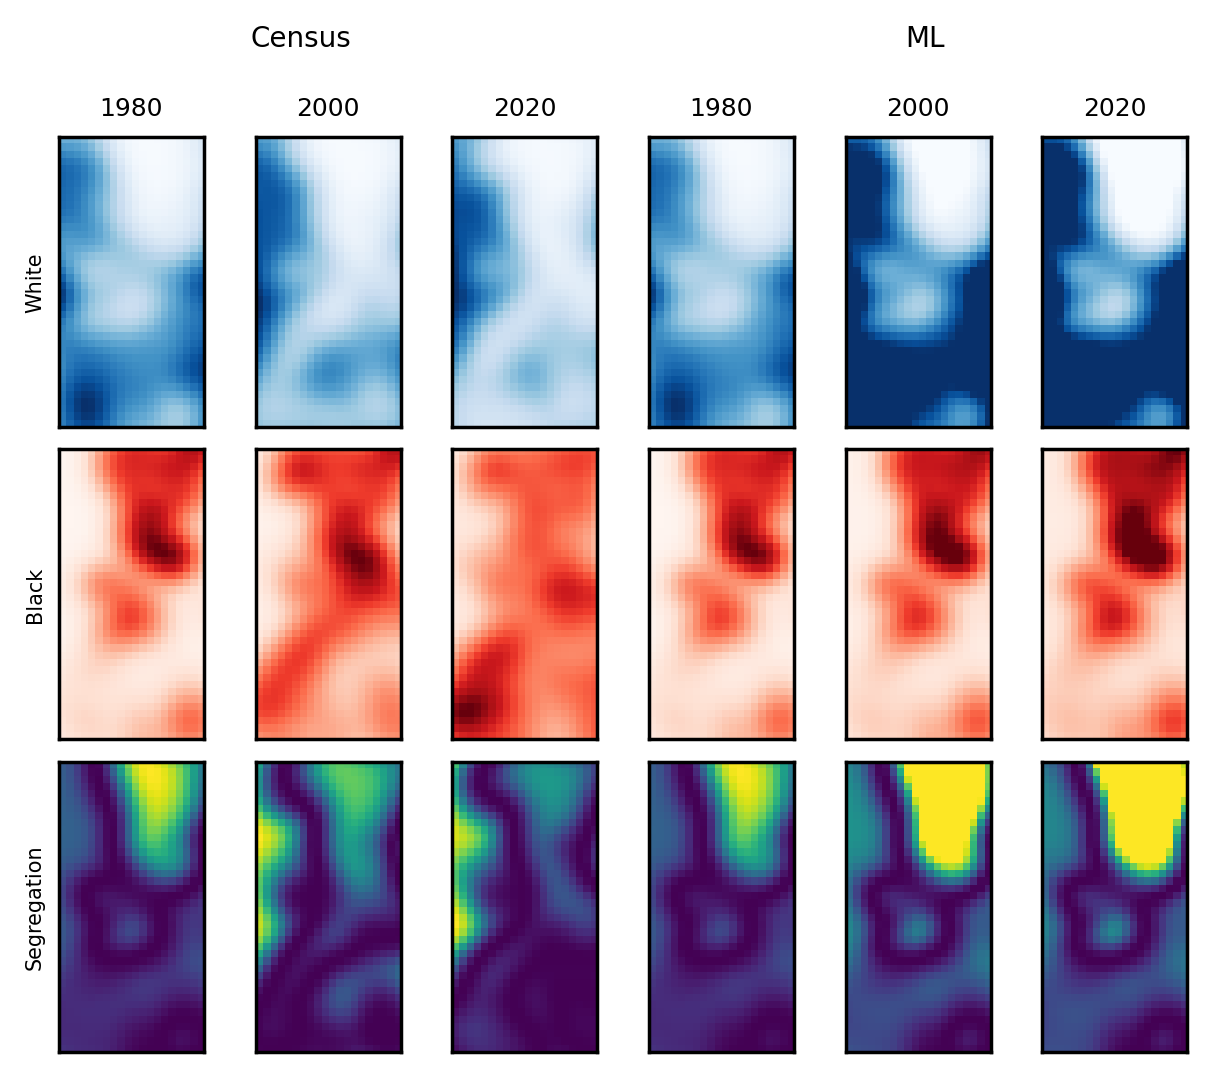

In [4]:
dataset = SociohydrodynamicsDataset(test_bbox=[5, 60, 40, 20])

batch = dataset.test_batch
with torch.no_grad():
    t = batch['t'].to(device)
    wb = torch.stack([batch['w'], batch['b']], dim=-3).to(device)
    wb_pred = model(t, wb[0:1]).squeeze()
    wb_pred[wb_pred < 0] = 0
    loss = F.l1_loss(wb, wb_pred)
    
    wb = wb.cpu().numpy()
    wb_pred = wb_pred.cpu().numpy()    
 
    
fig, ax = plt.subplots(3, 6, figsize=(5, 4))


cmaps = ['Blues', 'Reds', 'viridis']
for j, label in enumerate(['White', 'Black', 'Segregation']):
    cmap = cmaps[j]

    for i, tt in enumerate([0, 2, 4]):
        if label == 'Segregation':
            y0 = seg(wb[tt, 0], wb[tt, 1])
            y1 = seg(wb_pred[tt, 0], wb_pred[tt, 1])
            vmax = 2
        else:
            y0 = wb[tt, j]
            y1 = wb_pred[tt, j]
            vmax = np.max(wb[:, j])
        print(f'{label} {dataset.t[tt]}: y0: [{y0.min():.0f}, {y0.max():.0f}], y1: [{y1.min():.0f}, {y1.max():.0f}]')
            
        vmax = np.max(y0)
        ax[j, i].imshow(y0, cmap=cmap, vmin=0, vmax=vmax)
        ax[0, i].set_title(dataset.t[tt])
        
        ax[j, 3+i].imshow(y1, cmap=cmap, vmin=0, vmax=vmax)
        ax[0, 3+i].set_title(dataset.t[tt])

print(name, loss.item())
    
for a in ax.flatten():
    a.set(xticks=[], yticks=[])

ax[0, 0].set_ylabel('White')
ax[1, 0].set_ylabel('Black')
ax[2, 0].set_ylabel('Segregation')

fig.text(0.25, 1.05, 'Census', ha='center', va='top', fontsize=8)
fig.text(0.75, 1.05, 'ML', ha='center', va='top', fontsize=8)

plt.tight_layout()

White 1980: y0: [4, 16968], y1: [4, 16968]
White 1990: y0: [4, 8852], y1: [0, 16008]
White 2000: y0: [4, 7191], y1: [0, 14975]
White 2010: y0: [5, 6943], y1: [0, 13943]
White 2020: y0: [4, 6956], y1: [0, 11878]
Black 1980: y0: [0, 16447], y1: [0, 16447]
Black 1990: y0: [0, 15281], y1: [36, 16491]
Black 2000: y0: [5, 14176], y1: [83, 16538]
Black 2010: y0: [36, 5280], y1: [130, 16584]
Black 2020: y0: [5, 5593], y1: [223, 16678]


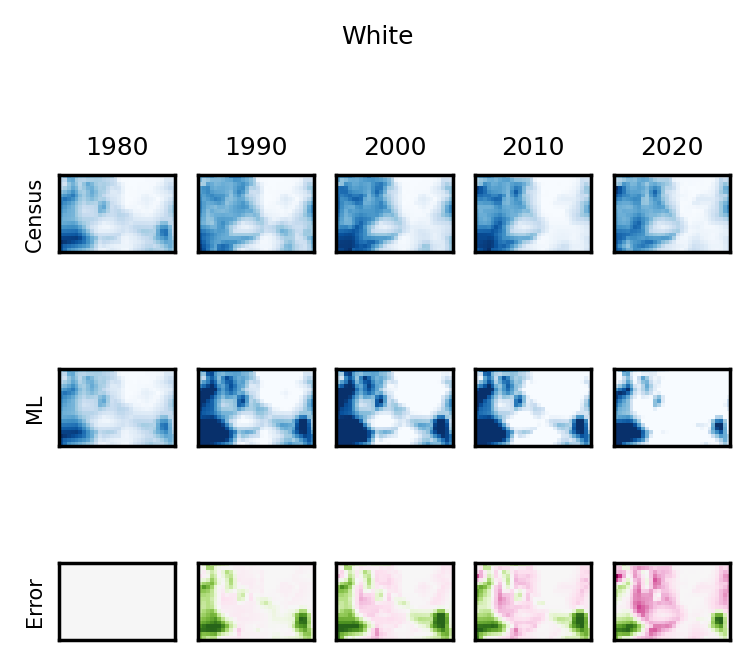

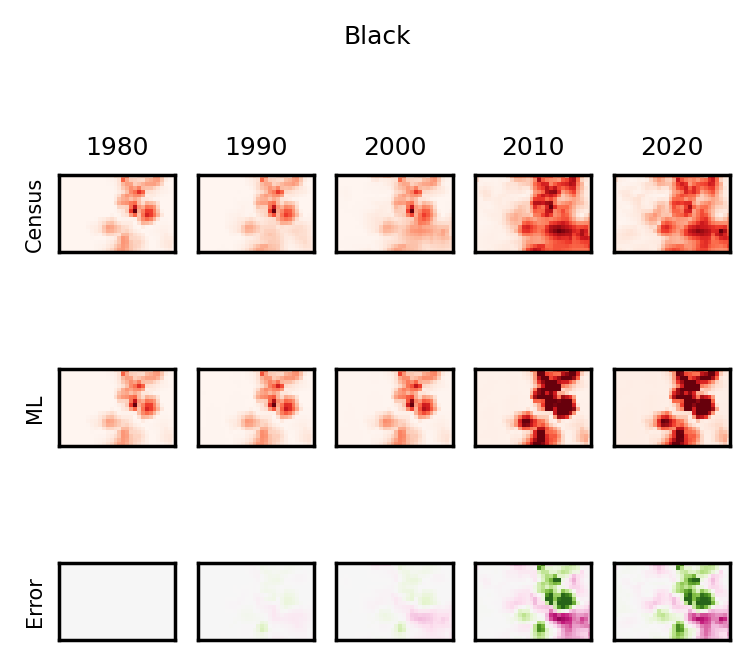

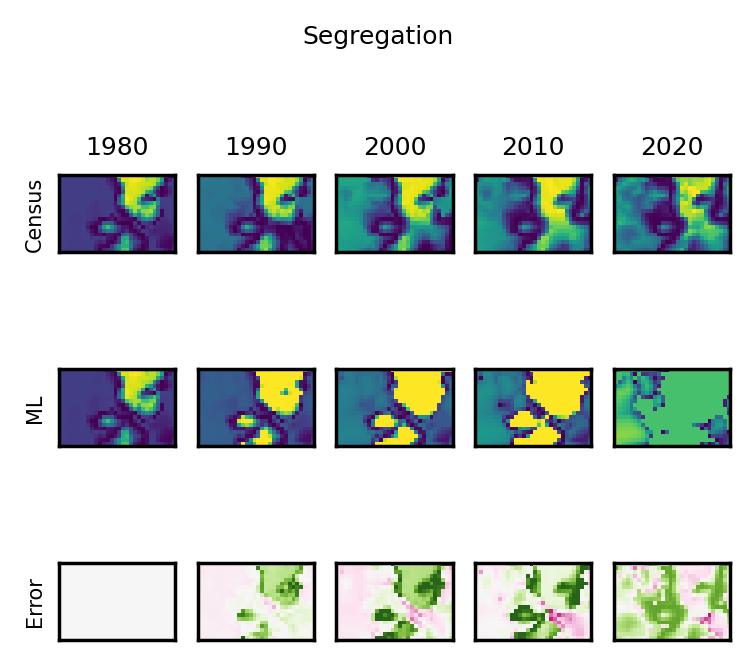

In [36]:
cmaps = ['Blues', 'Reds', 'viridis']
for j, title in enumerate(['White', 'Black', 'Segregation']):
    fig, ax = plt.subplots(3, 5, figsize=(3, 3))
    cmap = cmaps[j]

    for i in range(5):
        if title == 'Segregation':
            y0 = seg(wb[i, 0], wb[i, 1])
            y1 = seg(wb_pred[i, 0], wb_pred[i, 1])
        else:
            y0 = wb[i, j]
            y1 = wb_pred[i, j]
            print(f'{title} {dataset.t[i]}: y0: [{y0.min():.0f}, {y0.max():.0f}], y1: [{y1.min():.0f}, {y1.max():.0f}]')
        vmax = np.max(y0)
        ax[0, i].imshow(y0, cmap=cmap, vmin=0, vmax=vmax)
        ax[1, i].imshow(y1, cmap=cmap, vmin=0, vmax=vmax)
        ax[2, i].imshow(y1-y0, vmax=vmax, vmin=-vmax, cmap='PiYG')
        ax[0, i].set_title(dataset.t[i])
    
    for a in ax.flatten():
        a.set(xticks=[], yticks=[])

    ax[0, 0].set_ylabel('Census')
    ax[1, 0].set_ylabel('ML')
    ax[2, 0].set_ylabel('Error')
    fig.suptitle(title)
    plt.tight_layout()